#### 1. Import the Relevent Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchsummary import summary
import os
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'cv2'

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 2. Prepare the Dataset

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, root, transform_status=True):
        
        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")] 

        import itertools
        self.images_paths = list(itertools.chain.from_iterable(self.images_paths))

        import random
        random.shuffle(self.images_paths)

        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]
        self.transform_status = transform_status
        self.transform = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.images_paths)   
        
    def __getitem__(self, index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (64,64))
        image = torch.tensor(image/255).permute(2,0,1)
        if self.transform_status: image = self.transform(image)
        label = self.labels[index]
        
        return image.float().to(device), torch.tensor([label]).float().to(device)
    
    

In [4]:
data =  MyDataset("dataset_rgb/train", transform_status=False)

In [5]:
data.classes_names

{'River': 0,
 'HerbaceousVegetation': 1,
 'Residential': 2,
 'Highway': 3,
 'SeaLake': 4,
 'AnnualCrop': 5,
 'PermanentCrop': 6,
 'Forest': 7,
 'Industrial': 8,
 'Pasture': 9}

In [6]:
import random
image, label = data[random.randint(0, len(data))]

Image Size: 64 x 64 x 3
Label: tensor([6.], device='cuda:0')
PermanentCrop


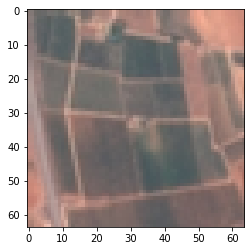

In [7]:
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()

In [8]:
train_dataset = MyDataset("dataset_rgb/train", transform_status=True)
test_dataset = MyDataset("dataset_rgb/test", transform_status=True)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

#### 3. Build the Model

In [9]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )
def build_model():
    model = nn.Sequential(
        conv_block(3, 64,3),
        conv_block(64, 128,3),
        conv_block(128, 256,3),
        conv_block(256, 512,3),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 10),
    )
        

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    return model.to(device) , loss_fn, optimizer


In [10]:
model , loss_function, optimizer = build_model()

In [11]:
summary(model, torch.zeros(1,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 63, 63]          --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─ReLU: 2-3                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 63, 63]          --
├─Sequential: 1-2                        [-1, 128, 62, 62]         --
|    └─Conv2d: 2-5                       [-1, 128, 63, 63]         73,856
|    └─BatchNorm2d: 2-6                  [-1, 128, 63, 63]         256
|    └─ReLU: 2-7                         [-1, 128, 63, 63]         --
|    └─MaxPool2d: 2-8                    [-1, 128, 62, 62]         --
├─Sequential: 1-3                        [-1, 256, 61, 61]         --
|    └─Conv2d: 2-9                       [-1, 256, 62, 62]         295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 62, 62]         512


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 63, 63]          --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─ReLU: 2-3                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 63, 63]          --
├─Sequential: 1-2                        [-1, 128, 62, 62]         --
|    └─Conv2d: 2-5                       [-1, 128, 63, 63]         73,856
|    └─BatchNorm2d: 2-6                  [-1, 128, 63, 63]         256
|    └─ReLU: 2-7                         [-1, 128, 63, 63]         --
|    └─MaxPool2d: 2-8                    [-1, 128, 62, 62]         --
├─Sequential: 1-3                        [-1, 256, 61, 61]         --
|    └─Conv2d: 2-9                       [-1, 256, 62, 62]         295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 62, 62]         512


#### 4. Build the Train and Accuracy Functions 

In [12]:
def train_batch(model, loss_function, optimizer, image, label):
    model.train()
    optimizer.zero_grad()
    prediction = model(image)
    loss = loss_function(prediction, label.long().squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

In [13]:
@torch.no_grad()
def accuracy(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == label.long().squeeze()
    return is_correct.cpu().numpy().tolist()

In [14]:
@torch.no_grad()
def validation_loss(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    loss = loss_function(prediction, label.long().squeeze())
    return loss.item()

#### 5. Train the Model

In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(50):
    print(f"Epoch: {epoch+1}")
    train_epoch_losses = []
    train_epoch_accuracies = []
    for image, label in iter(train_dataset_loader):
        loss = train_batch(model, loss_function, optimizer, image, label)
        train_epoch_losses.append(loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    train_losses.append(train_epoch_loss)
    
    for image, label in iter(train_dataset_loader):
        is_correct = accuracy(model, loss_function, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy*100:.2f}%")
    train_accuracies.append(train_epoch_accuracy)
    
    test_epoch_losses = []
    test_epoch_accuracies = []
    for image, label in iter(test_dataset_loader):
        loss = validation_loss(model, loss_function, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, loss_function, image, label)
        test_epoch_accuracies.extend(is_correct)
    test_epoch_loss = np.mean(test_epoch_losses)
    print(f"Test Loss: {test_epoch_loss:.4f}")
    test_losses.append(test_epoch_loss)
    test_epcoh_accuracy = np.mean(test_epoch_accuracies)
    print(f"Test Accuracy: {test_epcoh_accuracy*100:.2f}%")
    test_accuracies.append(test_epcoh_accuracy)


Epoch: 1
Train Loss: 1.0758
Train Accuracy: 74.15%
Test Loss: 0.7849
Test Accuracy: 72.64%
Epoch: 2
Train Loss: 0.7907
Train Accuracy: 77.67%
Test Loss: 0.6664
Test Accuracy: 75.00%
Epoch: 3
Train Loss: 0.6864
Train Accuracy: 78.57%
Test Loss: 0.6275
Test Accuracy: 77.40%
Epoch: 4
Train Loss: 0.6464
Train Accuracy: 74.78%
Test Loss: 0.7536
Test Accuracy: 74.22%
Epoch: 5
Train Loss: 0.5845
Train Accuracy: 70.50%
Test Loss: 1.3060
Test Accuracy: 68.99%
Epoch: 6
Train Loss: 0.5484
Train Accuracy: 86.18%
Test Loss: 0.4358
Test Accuracy: 85.50%
Epoch: 7
Train Loss: 0.5121
Train Accuracy: 87.71%
Test Loss: 0.4001
Test Accuracy: 85.98%
Epoch: 8
Train Loss: 0.4543
Train Accuracy: 84.49%
Test Loss: 0.5308
Test Accuracy: 82.35%
Epoch: 9
Train Loss: 0.4316
Train Accuracy: 89.55%
Test Loss: 0.3656
Test Accuracy: 87.44%
Epoch: 10
Train Loss: 0.4032
Train Accuracy: 90.63%
Test Loss: 0.3151
Test Accuracy: 89.42%
Epoch: 11
Train Loss: 0.3700
Train Accuracy: 84.99%
Test Loss: 0.5472
Test Accuracy: 82.9

#### 6. Visualize the Train Loss/Accuracy and the Test Loss/Accuracy

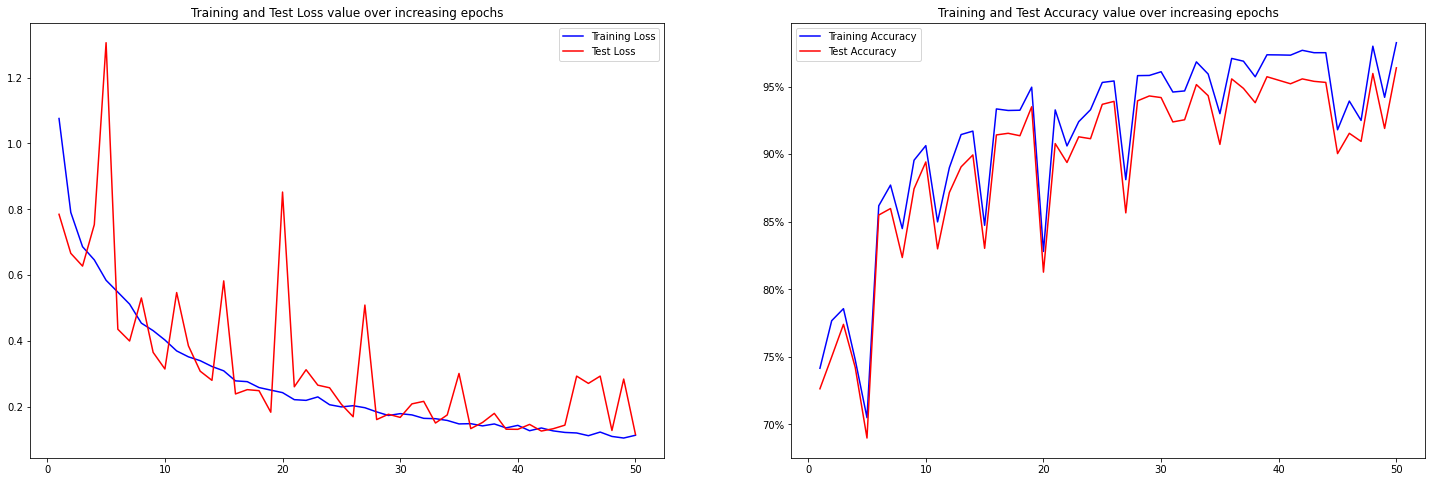

In [17]:
epochs = np.arange(50)+1
plt.figure(figsize=(25,8))
plt.subplot(121)
plt.title('Training and Test Loss value over increasing epochs')
plt.plot(epochs, train_losses,'b', label='Training Loss')
plt.plot(epochs, test_losses,'r', label='Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Training and Test Accuracy value over increasing epochs')
plt.plot(epochs, train_accuracies,'b', label='Training Accuracy')
plt.plot(epochs, test_accuracies,'r', label='Test Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()